In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix,roc_curve, f1_score, ConfusionMatrixDisplay, PrecisionRecallDisplay,precision_score, recall_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
import gc
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


c:\Users\asude\anaconda3\envs\ML\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Train-Test Split

In [2]:
df = pd.read_parquet("processed_data/agg_data_preprocess_2.gzip")
labels = pd.read_feather("train_labels.ftr")

In [3]:
intersection_labels = np.intersect1d(df["customer_ID"], labels["customer_ID"]).tolist()
df_Y = labels.loc[labels["customer_ID"].isin(intersection_labels),:]


In [4]:
df = df.drop(columns=["customer_ID"])
df_Y = df_Y.drop(columns=["customer_ID"])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df, df_Y, test_size=0.20)
print(X_train.shape)
print(X_test.shape)

(367130, 1265)
(91783, 1265)


# XGBoost Classifier

In [6]:
xgboost_parameters = {
    'verbosity': 1,
    'max_depth':4, 
    'learning_rate':0.04, 
    'subsample':0.71,
    'colsample_bytree':0.72, 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method': 'gpu_hist',
    'enable_categorical': True
    }

In [7]:
xgb_clf = xgb.XGBClassifier(**xgboost_parameters)
print(xgb_clf.get_params())

{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.72, 'early_stopping_rounds': None, 'enable_categorical': True, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.04, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.71, 'tree_method': 'gpu_hist', 'validate_parameters': None, 'verbosity': 1}


In [8]:
cv_results = cross_validate(xgb_clf, X_train, y_train, cv=5, scoring=('roc_auc', 'precision', 'recall'), return_train_score=True)
print(sorted(cv_results.keys()))

['fit_time', 'score_time', 'test_precision', 'test_recall', 'test_roc_auc', 'train_precision', 'train_recall', 'train_roc_auc']


In [9]:
print("Precision on validation set: " , np.mean(cv_results['test_precision']))
print("Recall on validation set: " , np.mean(cv_results['test_recall']))
print("Roc_auc on validation set: " , np.mean(cv_results['test_roc_auc']))
print("---------------------")
print("Precision on train set: " , np.mean(cv_results['train_precision']))
print("Recall on train set: " , np.mean(cv_results['train_recall']))
print("Roc_auc on train set: " , np.mean(cv_results['train_roc_auc']))


Precision on validation set:  0.7928467856792207
Recall on validation set:  0.7877524460627529
Roc_auc on validation set:  0.9527503437310904
---------------------
Precision on train set:  0.7957325520994837
Recall on train set:  0.7908717131392005
Roc_auc on train set:  0.9540572338873696


In [10]:
def display_metrics(predictor,y_true, y_pred_labels, y_pred_score):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    accuracy = accuracy_score(y_true, y_pred_labels)
    print("Accuracy: ", accuracy)
    precision = precision_score(y_true, y_pred_labels)
    print("Precision score: ", precision)
    recall = recall_score(y_true, y_pred_labels)
    print("Recall score: ", recall)
    f1 = f1_score(y_true, y_pred_labels)
    print("F1 score: ", f1)
    rocauc = roc_auc_score(y_true, y_pred_labels)
    print("roc_auc score: ", rocauc)
    conf_matrix = confusion_matrix(y_true, y_pred_labels)
    fpr, tpr, _ = roc_curve(y_true, y_pred_score[:, 1])
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax2)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=predictor.classes_).plot(ax=ax1)

In [11]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.72,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='logloss', feature_types=None, gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.04, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

Accuracy:  0.8931413940566012
Precision score:  0.7954523771664812
Recall score:  0.790100448543812
F1 score:  0.7927673803147235
roc_auc score:  0.8595999678013524


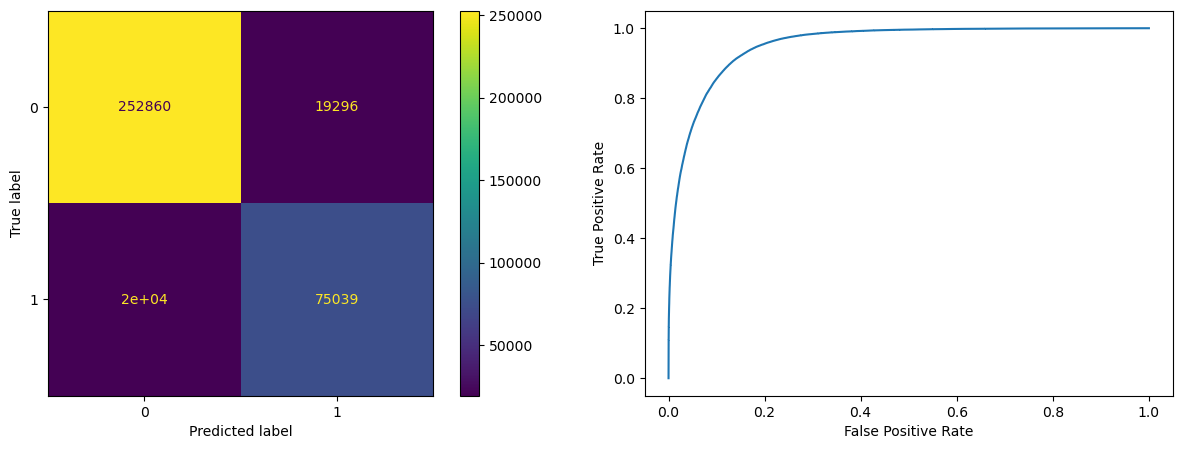

In [12]:
pred_train = xgb_clf.predict(X_train)
pred_proba_train = xgb_clf.predict_proba(X_train)
display_metrics(xgb_clf, y_train, pred_train, pred_proba_train)

Accuracy:  0.8924746412734385
Precision score:  0.7943590822984635
Recall score:  0.7910622956317599
F1 score:  0.7927072612321201
roc_auc score:  0.8595744871849269


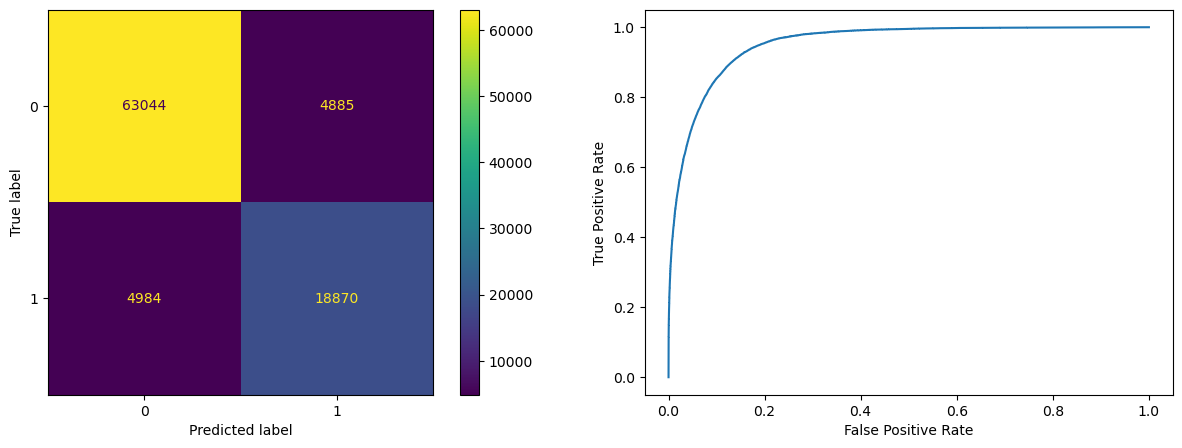

In [13]:
pred_test = xgb_clf.predict(X_test)
pred_prob = xgb_clf.predict_proba(X_test)
display_metrics(xgb_clf, y_test, pred_test, pred_prob)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

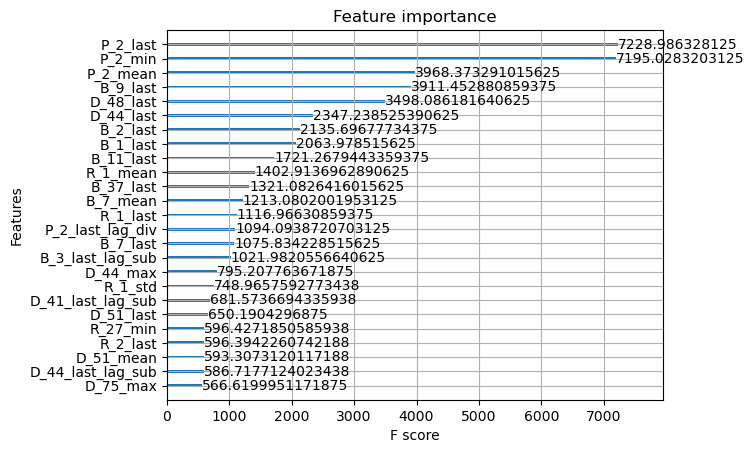

In [16]:
xgb.plot_importance(xgb_clf, importance_type="gain", max_num_features=25)

# Hyperparameter Optimization

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'alpha' : hp.uniform('alpha', 0, 10),
        'lambda' : hp.uniform('lambda', 1,10),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'subsample': hp.uniform('subsample', 0.5, 1),
        'eta': hp.uniform('eta', 0.1, 1)
    }

In [109]:
percentage = 0.50
slice = int(len(X_train) * percentage)
X_train_hyperopt = X_train[0: slice]
y_train_hyperopt = y_train[0: slice]

percentage = 0.1
slice = int(len(X_train) * percentage)
X_val_hyperopt = X_train.tail(slice)
y_val_hyperopt = y_train.tail(slice)

In [112]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    alpha = int(space['alpha']), eta=space['eta'], subsample=space['subsample'], 
                    reg_lambda=space['lambda'],
                    min_child_weight=int(space['min_child_weight']), enable_categorical=True,
                    tree_method='gpu_hist', eval_metric="auc",  early_stopping_rounds=10,
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train_hyperopt, y_train_hyperopt), ( X_val_hyperopt, y_val_hyperopt)]
    
    clf.fit(X_train_hyperopt, y_train_hyperopt,
            eval_set=evaluation, 
           verbose=False)
    

    pred = clf.predict(X_val_hyperopt)
    accuracy = accuracy_score(y_val_hyperopt, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [113]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

SCORE:                                                
0.8881044213462335                                    
SCORE:                                                                           
0.8863611601403325                                                               
SCORE:                                                                           
0.8851408772962018                                                               
SCORE:                                                                           
0.8865790677910701                                                               
SCORE:                                                                           
0.88640474167048                                                                 
SCORE:                                                                           
0.8828528469634569                                                               
SCORE:                                                                

In [114]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'alpha': 0.07663197830524604, 'colsample_bytree': 0.8132861752295426, 'eta': 0.5536795351588868, 'gamma': 5.091402485128997, 'lambda': 5.6434633875265865, 'max_depth': 16.0, 'min_child_weight': 4.0, 'subsample': 0.9434555729790581}


In [132]:
best_xgboost_parameters = {
    'alpha': 0.0766,
    'colsample_bytree': 0.8133,
    'eta': 0.5537,
    'gamma': 5.0914,
    'lambda': 5.6435,
    'max_depth': 6,
    'min_child_weight': 4.0,
    'subsample': 0.9435,
    'n_estimators': 100,
    'enable_categorical':True,
    'tree_method':'gpu_hist',
    'eval_metric': 'auc',
}

In [133]:
best_xgb_clf =xgb.XGBClassifier(**best_xgboost_parameters)
best_xgb_clf.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8133,
 'early_stopping_rounds': None,
 'enable_categorical': True,
 'eval_metric': 'auc',
 'feature_types': None,
 'gamma': 5.0914,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 6,
 'max_leaves': None,
 'min_child_weight': 4.0,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.9435,
 'tree_method': 'gpu_hist',
 'validate_parameters': None,
 'verbosity': None,
 'alpha': 0.0766,
 'eta': 0.5537

In [134]:
best_xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=0.0766, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8133,
              early_stopping_rounds=None, enable_categorical=True, eta=0.5537,
              eval_metric='auc', feature_types=None, gamma=5.0914, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=5.6435,
              learning_rate=0.55369997, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=4.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, ...)

Accuracy:  0.8925073270649249
Precision score:  0.7936480833262187
Recall score:  0.7869962749746021
F1 score:  0.790308182784272
roc_auc score:  0.858036936472028


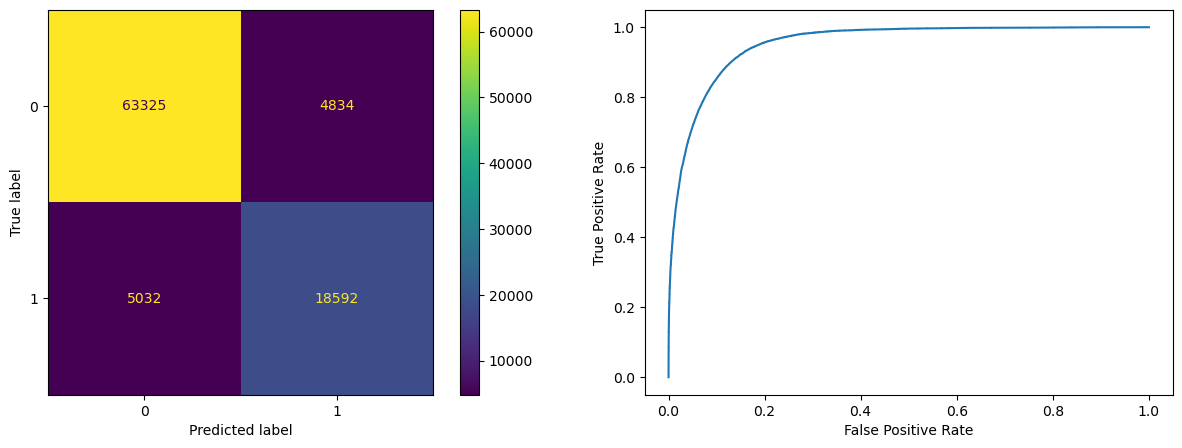

In [135]:
pred_test = best_xgb_clf.predict(X_test)
pred_prob = best_xgb_clf.predict_proba(X_test)
display_metrics(best_xgb_clf, y_test, pred_test, pred_prob)

In [136]:
best_xgb_clf.save_model("xgboost_model.json")